In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgba2rgb, gray2rgb
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Set paths
TRAIN_DATADIR = "../data/train_directory"
VAL_DATADIR = "../data/val_directory"
TEST_DATADIR = "../data/test_directory"

In [3]:
# Preprocess images for SVM model

def process_image(file_path, label, target_size=(64, 64)):
    """
    Preprocesses an image by reading it from the given file path, converting it to RGB if necessary,
    resizing it to the target size, flattening it, and normalizing its pixel values.

    Args:
        file_path (str): The path to the image file.
        label: The label associated with the image.
        target_size (tuple, optional): The desired size of the image after resizing. Defaults to (64, 64).

    Returns:
        tuple: A tuple containing the flattened and normalized image array and the label.
    """
    image = imread(file_path)
    if image.shape[-1] == 4:
        image = rgba2rgb(image)
    elif image.ndim == 2:
        image = gray2rgb(image)
    image = resize(image, target_size, anti_aliasing=True)
    image_flat = image.flatten()
    return image_flat / 255.0, label

def preprocess_images_for_svm(directory, target_size=(64, 64)):
    class_names = sorted(os.listdir(directory))
    # Load images and apply pre-processing in parallel
    results = Parallel(n_jobs=-1)(delayed(process_image)(os.path.join(directory, class_name, file_name), label, target_size)
                                  for label, class_name in enumerate(class_names)
                                  for file_name in os.listdir(os.path.join(directory, class_name))
                                  if os.path.isdir(os.path.join(directory, class_name)))
    images, labels = zip(*results)
    return np.array(images), np.array(labels)

def load_svm_datasets(train_path, val_path, target_size=(64, 64)):
    X_train, y_train = preprocess_images_for_svm(train_path, target_size)
    X_val, y_val = preprocess_images_for_svm(val_path, target_size)
    X_test, y_test = preprocess_images_for_svm(TEST_DATADIR, target_size)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_svm_datasets(TRAIN_DATADIR, VAL_DATADIR)

In [4]:
# Apply SMOTE only on the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify sizes of data sets, including the SMOTE-augmented training data
print(f"Original train size: {len(X_train)}")
print(f"SMOTE train size: {len(X_train_smote)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Original train size: 9801
SMOTE train size: 16225
Validation size: 1090
Test size: 1211


In [ ]:
# Initialize PCA with high number of components (same as the original number of features in the data)
pca = RandomizedPCA(n_components=9801, random_state=42)
pca.fit(X_train)

# Plotting the cumulative explained variance ratio to evaluate how many principal components should be retained
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# After plotting the cumulative explained variance ratio, we can visually inspect where the
# curve starts to plateau and choose the number of components accordingly.

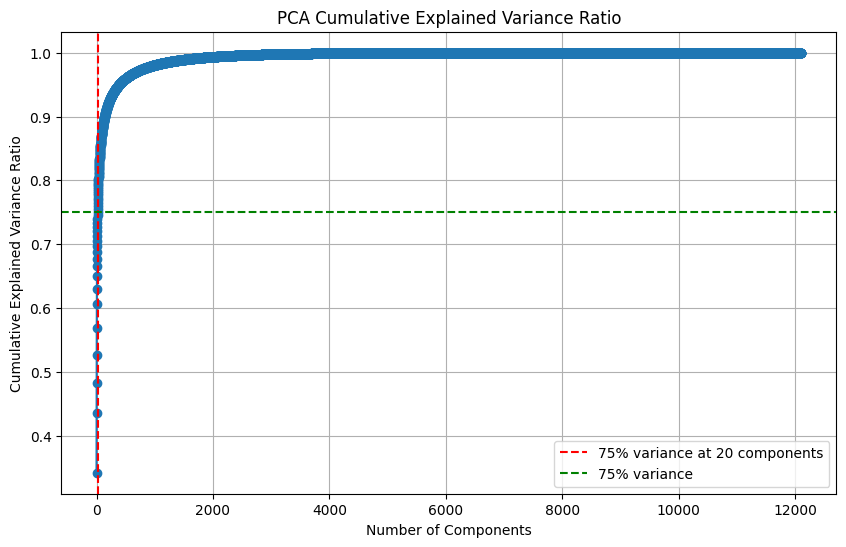

In [9]:
# Calculate the cumulative sum of explained variance ratios
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 75% of the variance
components_75_variance = np.where(cumulative_variance_ratio >= 0.75)[0][0] + 1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance Ratio')
plt.grid(True)

# Add a vertical line at the component that first reaches 75% variance explained
plt.axvline(x=components_75_variance, color='r', linestyle='--', label=f'75% variance at {components_75_variance} components')
plt.axhline(y=0.75, color='green', linestyle='--', label='75% variance')
plt.legend()

plt.show()

In [8]:
# Find the number of components that explain at least 90% of the variance
n_components_90 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.90)[0][0] + 1

print(f"Number of components to explain 90% variance: {n_components_90}")

Number of components to explain 90% variance: 140


In [46]:
# Calculate how much variance is expalined by 20 components
var_explained_by_20 = np.cumsum(pca.explained_variance_ratio_)[19]
print(f"20 components expalain {var_explained_by_20} of the variance.")

20 components expalain 0.7509506096150396 of the variance.


In [10]:
# Calculating custom class weights

# Varify class labels
unique_classes = np.unique(y_train)
print("Unique classes in y_train:", unique_classes)

# Obtain unique class labels from the training data
class_labels = np.unique(y_train)
# Calculate the weights for each class to handle class imbalance
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
# Convert computed weights into a dictionary mapping each class label to its corresponding weight
class_weights = dict(zip(class_labels, weights))

Unique classes in y_train: [ 0  1  2  3  4  5  6  7  8  9 10]


In [21]:
# Setting up the PCA and SVM within a pipeline

# Initialize a PCA model to reduce the dataset to 20 principal components
pca = RandomizedPCA(n_components=20, whiten=True, random_state=42)
# Initialize an SVM classifier
svm = SVC(kernel='rbf', C = 10.0, gamma='auto', class_weight=class_weights)
# Combine PCA and SVM into a single pipeline, creating a streamlined workflow
model = make_pipeline(pca, svm)

Validation accuracy = 0.6160198183319571
                     precision    recall  f1-score   support

 Cardboard_combined       0.58      0.61      0.60       134
     Metal combined       0.56      0.60      0.58       168
      Textile Trash       0.37      0.53      0.43        38
         Vegetation       0.44      0.50      0.47        32
            battery       0.71      0.75      0.73       102
biological combined       0.61      0.58      0.60       141
     brown combined       0.55      0.61      0.58        56
     green combined       0.76      0.76      0.76        72
     paper combined       0.62      0.59      0.61       168
   plastic combined       0.65      0.54      0.59       163
     white combined       0.72      0.69      0.70       137

           accuracy                           0.62      1211
          macro avg       0.60      0.61      0.60      1211
       weighted avg       0.62      0.62      0.62      1211



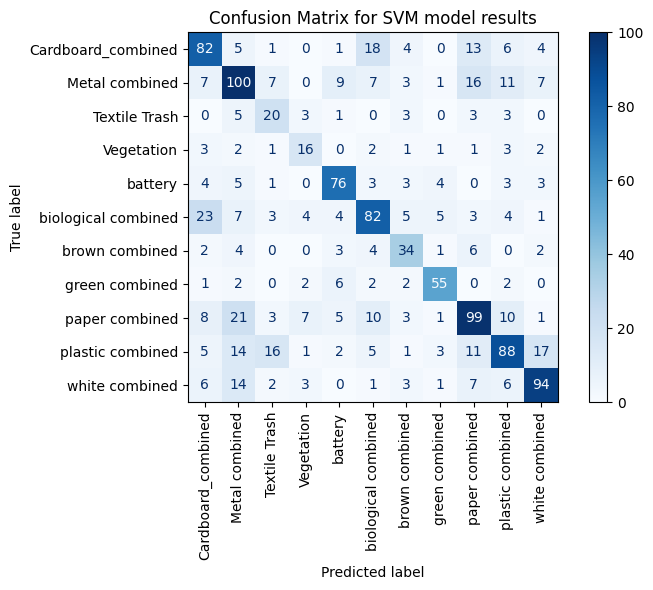

In [22]:
# Train the model on the training data
model.fit(X_train, y_train)

# Predict the labels of the validation set
y_pred = model.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy = {accuracy}")

target_names = sorted(os.listdir(TRAIN_DATADIR))

# Print the classification report
print(classification_report(y_val, y_pred, target_names=target_names))

# Print the confusion matrix
cm = confusion_matrix(y_val, y_pred)
# Plot with ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

# Use a color map of choice; 'viridis', 'plasma', 'inferno', 'magma', 'cividis' are some good options
disp.plot(cmap='Blues', ax=ax, colorbar=True)

# Enhance readability:
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Additional customizations
plt.title('Confusion Matrix for SVM model results')
plt.grid(False)  # Turn off the grid lines inside the matrix (optional)

# Show the plot
plt.tight_layout()
plt.show()

Validation accuracy = 0.5559633027522936
                     precision    recall  f1-score   support

 Cardboard_combined       0.50      0.54      0.52       125
     Metal combined       0.42      0.50      0.45       147
      Textile Trash       0.25      0.17      0.20        29
         Vegetation       0.54      0.56      0.55        39
            battery       0.52      0.68      0.59        88
biological combined       0.58      0.58      0.58       130
     brown combined       0.65      0.69      0.67        58
     green combined       0.81      0.75      0.78        61
     paper combined       0.56      0.55      0.56       145
   plastic combined       0.62      0.45      0.52       164
     white combined       0.67      0.62      0.64       104

           accuracy                           0.56      1090
          macro avg       0.56      0.55      0.55      1090
       weighted avg       0.56      0.56      0.56      1090



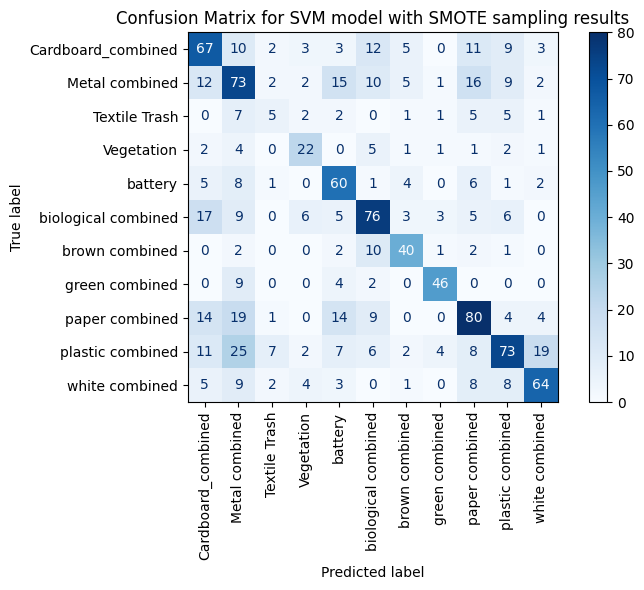

In [12]:
# Model 2, inlcuding SMOTE-sampled training data

pca_2 = RandomizedPCA(n_components=50, whiten=True, random_state=42)
svm_2 = SVC(kernel='rbf', C = 100, gamma='auto', class_weight=class_weights)
model_2 = make_pipeline(pca_2, svm_2)

# Train the model on the training data that was altered with smote
model_2.fit(X_train_smote, y_train_smote)

# Predict the labels of the validation set
y_pred = model_2.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy = {accuracy}")

target_names = sorted(os.listdir(TRAIN_DATADIR))

# Print the classification report
print(classification_report(y_val, y_pred, target_names=target_names))

# Print the confusion matrix
cm_smote = confusion_matrix(y_val, y_pred)
# Plot with ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=target_names)


disp_smote.plot(cmap='Blues', ax=ax, colorbar=True)

# Enhance readability:
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Additional customizations
plt.title('Confusion Matrix for SVM model with SMOTE sampling results')
plt.grid(False)  # Turn off the grid lines inside the matrix (optional)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Define a parameter grid specifying the parameters to be tested
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto', 0.1, 1],
    'pca__n_components': [18, 20, 50, 140, 300],
    'svc__kernel' : ['poly', 'rbf']
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
# Fit GridSearchCV on the training data to find the best parameters
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

In [8]:
# Try Randomized Search instead of testing every combination

# Define a distribution of parameters to randomly sample from during optimization
param_distributions = {
    'svc__C': np.logspace(-3, 2, 6),  # Logarithmically spaced values
    'svc__gamma': ['scale', 'auto', 0.01, 1],
    'pca__n_components': [20, 50, 140]
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(model_2, param_distributions, n_iter=20, scoring='accuracy', cv=3, random_state=42)
# Fit RandomizedSearchCV on the SMOTE sampled training data to find the best parameters
random_search.fit(X_train_smote, y_train_smote)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

# Output for RandomizedSearchCV for SMOTE sampled data
# Best parameters: {'svc__gamma': 'auto', 'svc__C': 100.0, 'pca__n_components': 50}
# Best cross-validation score: 0.78

Best parameters: {'svc__gamma': 'auto', 'svc__C': 100.0, 'pca__n_components': 50}
Best cross-validation score: 0.78


Test accuracy = 0.5975206611570248
                     precision    recall  f1-score   support

 Cardboard_combined       0.58      0.60      0.59       148
     Metal combined       0.52      0.57      0.54       152
      Textile Trash       0.24      0.29      0.26        31
         Vegetation       0.61      0.71      0.65        52
            battery       0.71      0.68      0.70        88
biological combined       0.61      0.60      0.61       148
     brown combined       0.70      0.56      0.62        68
     green combined       0.77      0.83      0.80        72
     paper combined       0.59      0.61      0.60       157
   plastic combined       0.60      0.48      0.53       189
     white combined       0.59      0.65      0.62       105

           accuracy                           0.60      1210
          macro avg       0.59      0.60      0.59      1210
       weighted avg       0.60      0.60      0.60      1210



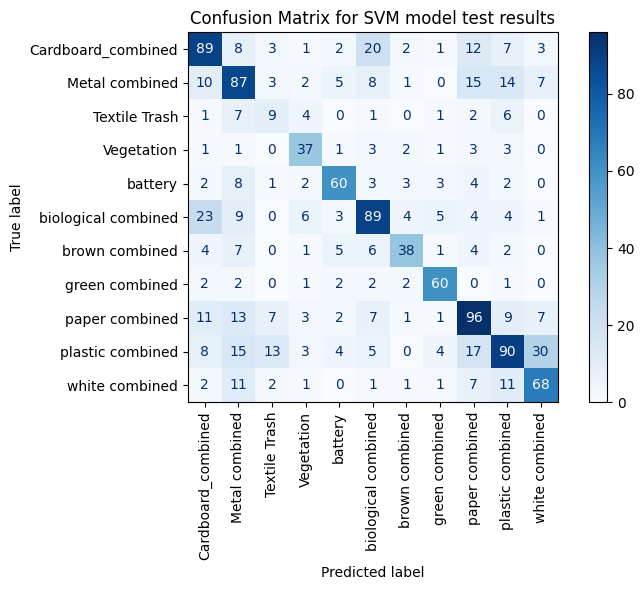

In [23]:
# After finding a sufficient-good parameter combination from RandomizedSearchCV, using the same
# for retraining the model, and validating using the validation set, it is run on the test set

# Predict the labels of the test set
y_test_pred = model.predict(X_test)

# Calculate the accuracy of the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy = {test_accuracy}")

target_names = sorted(os.listdir(TRAIN_DATADIR))

# Print the classification report for the test set
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Print the confusion matrix for the test set
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot with ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=target_names)

# Use a color map of choice; 'viridis', 'plasma', 'inferno', 'magma', 'cividis' are some good options
test_disp.plot(cmap='Blues', ax=ax, colorbar=True)

# Enhance readability:
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Additional customizations
plt.title('Confusion Matrix for SVM model test results')
plt.grid(False)  # Turn off the grid lines inside the matrix

# Show the plot
plt.tight_layout()
plt.show()

Test accuracy = 0.5631709331131296
                     precision    recall  f1-score   support

 Cardboard_combined       0.46      0.60      0.52       139
     Metal combined       0.48      0.51      0.49       163
      Textile Trash       0.38      0.31      0.34        32
         Vegetation       0.66      0.49      0.56        43
            battery       0.60      0.78      0.68        98
biological combined       0.59      0.59      0.59       145
     brown combined       0.64      0.56      0.60        64
     green combined       0.78      0.75      0.77        68
     paper combined       0.57      0.53      0.55       161
   plastic combined       0.58      0.52      0.55       182
     white combined       0.60      0.48      0.53       116

           accuracy                           0.56      1211
          macro avg       0.58      0.56      0.56      1211
       weighted avg       0.57      0.56      0.56      1211



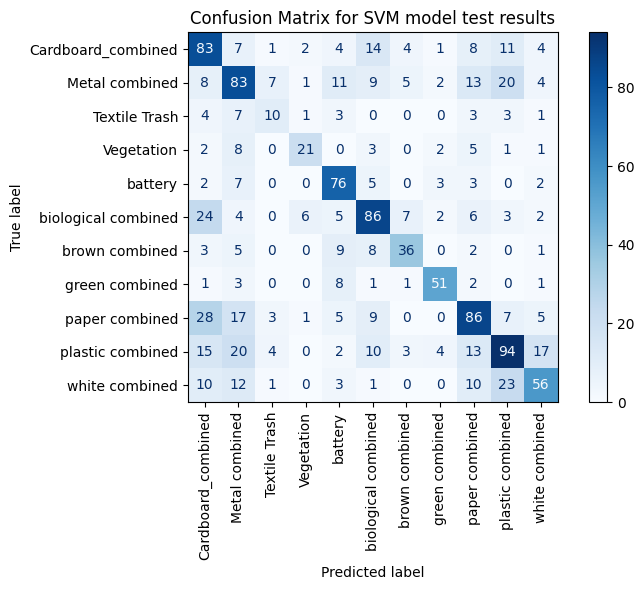

In [13]:
# After finding a sufficient-good parameter combination from RandomizedSearchCV, using the same
# for retraining the model, and validating using the validation set, it is run on the test set (for SMOTE sampled data)

# Predict the labels of the test set
y_test_pred_smote = model_2.predict(X_test)

# Calculate the accuracy of the model on the test set
test_accuracy_smote = accuracy_score(y_test, y_test_pred_smote)
print(f"Test accuracy = {test_accuracy_smote}")

target_names = sorted(os.listdir(TRAIN_DATADIR))

# Print the classification report for the test set
print(classification_report(y_test, y_test_pred_smote, target_names=target_names))

# Print the confusion matrix for the test set
test_cm_smote = confusion_matrix(y_test, y_test_pred_smote)

# Plot with ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
test_disp_smote = ConfusionMatrixDisplay(confusion_matrix=test_cm_smote, display_labels=target_names)

# Use a color map of choice; 'viridis', 'plasma', 'inferno', 'magma', 'cividis' are some good options
test_disp_smote.plot(cmap='Blues', ax=ax, colorbar=True)

# Enhance readability:
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Additional customizations
plt.title('Confusion Matrix for SVM model test results')
plt.grid(False)  # Turn off the grid lines inside the matrix

# Show the plot
plt.tight_layout()
plt.show()